In [60]:
import collections
import os
import json
import logging
import string
import itertools

from scipy.stats import entropy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import statsmo dels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import networkx as nx

if os.getcwd().endswith('notebook'):
    os.chdir('..')

from rna_learn.alphabet import ALPHABET_DNA, CODON_REDUNDANCY
from rna_learn.codon_bias.graph import load_codon_bias
from rna_learn.codon_bias.distance import compute_codon_bias_distance

In [2]:
sns.set(palette='colorblind', font_scale=1.3)
palette = sns.color_palette()
logging.basicConfig(level=logging.INFO, format="%(asctime)s (%(levelname)s) %(message)s")
logger = logging.getLogger(__name__)

In [3]:
db_path = os.path.join(os.getcwd(), 'data/db/seq.db')
engine = create_engine(f'sqlite+pysqlite:///{db_path}')

## Load tripets distribution

In [4]:
possible_codons = sorted(CODON_REDUNDANCY.keys())

In [5]:
nucleotide_bias = load_codon_bias(engine, os.path.join(os.getcwd(), 'data/nucleotide_bias.csv'))
doublet_bias = load_codon_bias(engine, os.path.join(os.getcwd(), 'data/doublet_bias.csv'))
triplet_bias = load_codon_bias(engine, os.path.join(os.getcwd(), 'data/triplet_bias.csv'))

## Plot triplets distribution

In [6]:
def plot_triplets_distribution(triplet_bias, possible_codons, species_taxids):
    y_species = []
    for species_taxid in species_taxids:
        df = triplet_bias[triplet_bias['species_taxid'] == species_taxid]

        ratios = []
        codon_count_sum = sum((df[cod] for cod in possible_codons)).sum()
        for codon in possible_codons:
            ratio = df[codon].sum() / codon_count_sum
            ratios.append(ratio)
            
        y_species.append(ratios)
        
    x = list(reversed(sorted(possible_codons)))
        
    _, ax = plt.subplots(1, 1, figsize=(12, 18))
    
    data = {}
    for i, species_taxid in enumerate(species_taxids):
        species = triplet_bias[triplet_bias['species_taxid'] == species_taxid]['species'].iloc[0]
        data[species] = y_species[i]
        
    pd.DataFrame(
        data, 
        index=x,
    ).plot.barh(ax=ax, alpha=1)
    
    ax.set_xlabel('Probability of occurence')
    ax.set_title('Genome-wide nucleotide triplets distribution')
    
    return ax

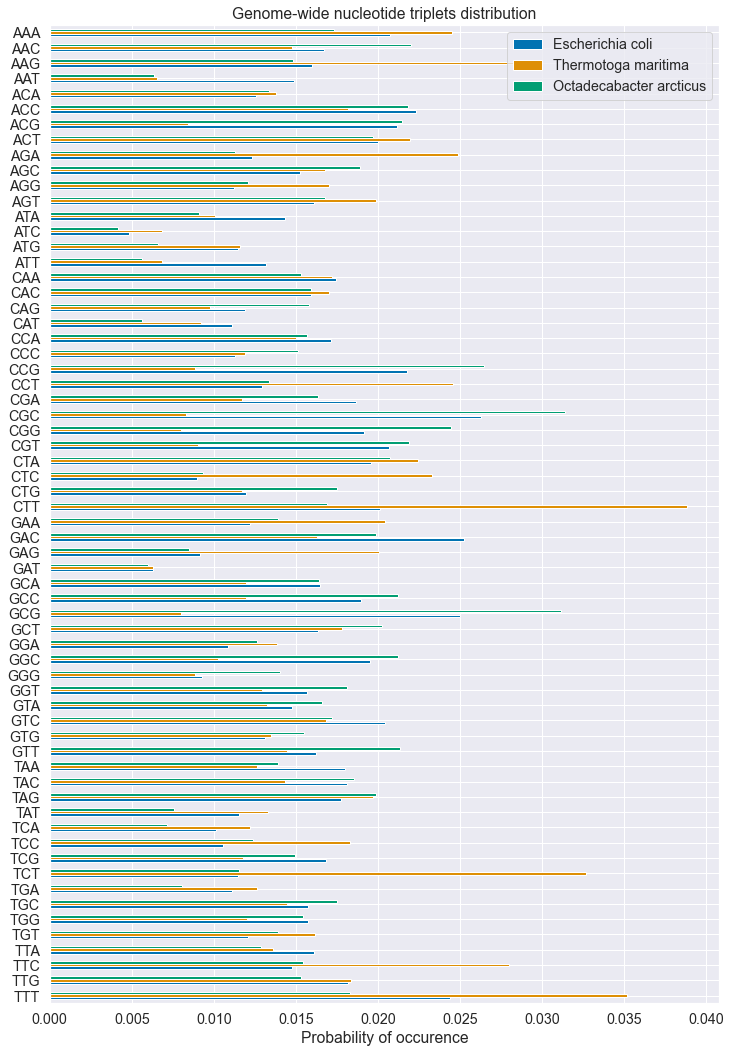

In [7]:
plot_triplets_distribution(triplet_bias, possible_codons, species_taxids=[562, 2336, 53946]);

## Good predictor for growth temperature? 

In [8]:
def fit_linear_regression(y_actual, x):
    X = sm.add_constant(x)
    model = sm.OLS(y_actual, X)
    results = model.fit()
    y_fit = results.predict(X)
    return results, y_fit

In [74]:
def plot_true_vs_prediction_per_specie(y_true, y_pred, ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(8, 8))
    
    palette = sns.color_palette()
    
    x_straight = range(int(np.min(y_true)) - 1, int(np.max(y_true)) + 1)
    ax.plot(x_straight, x_straight, '--', color=palette[1], linewidth=2)
    
    ax.scatter(y_true, y_pred, color=palette[0], alpha=0.5, label='Species')
    
    ax.set_xlabel('Temperature °C (truth)')
    ax.set_ylabel('Temperature °C (prediction)')
    return ax


def compute_and_plot_pattern_against_ogt(y_actual, x, results, ax=None):
    palette = sns.color_palette()

    X = sm.add_constant(x)
    y_fit = results.predict(X)
    
    std, upper, lower = wls_prediction_std(results)
    
    ax = plot_true_vs_prediction_per_specie(y_actual, y_fit, ax=ax)
    
    df_data = [
        [y_actual[i], y_fit[i], std[i]]
        for i in range(len(y_actual))
    ]
    df = pd.DataFrame(df_data, columns=['growth_tmp_actual', 'growth_tmp_prediction', 'growth_tmp_std'])
    
    pred_mean = df[['growth_tmp_actual', 'growth_tmp_prediction']].groupby('growth_tmp_actual').mean()
    std_mean = df[['growth_tmp_actual', 'growth_tmp_std']].groupby('growth_tmp_actual').mean().reset_index()
    x_fill = std_mean['growth_tmp_actual'].values
    x_base = pred_mean['growth_tmp_prediction'].values
    y_fill_1 = x_base - 2 * std_mean['growth_tmp_std'].values
    y_fill_2 = x_base + 2 * std_mean['growth_tmp_std'].values
    ax.fill_between(x_fill, y_fill_1, y_fill_2, alpha=0.2, color=palette[1], label='Uncertainty');

    ax.legend(loc='upper left')
    
    return ax, y_fit


def compute_mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))


def compute_rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

In [66]:
def fit_model_and_plot(df):
    ratio_columns = [c for c in df.columns if c.endswith('_ratio')]

    x_train = df[~df['in_test_set']][ratio_columns].values
    y_train = df[~df['in_test_set']]['growth_tmp'].values

    x_test = df[df['in_test_set']][ratio_columns].values
    y_test = df[df['in_test_set']]['growth_tmp'].values

    results, y_fit_train = fit_linear_regression(y_train, x_train)

    ax, y_fit_test = compute_and_plot_pattern_against_ogt(y_test, x_test, results)
    
    return compute_mae(y_test, y_fit_test), results.rsquared, ax

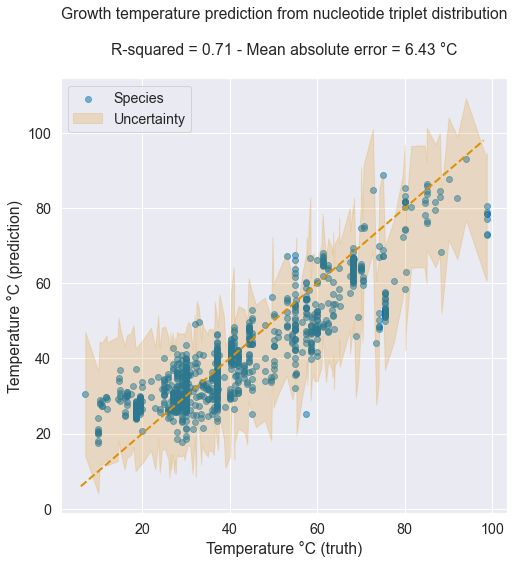

In [75]:
mae, r2, ax = fit_model_and_plot(triplet_bias)
ax.set_title((
    f'Growth temperature prediction from nucleotide triplet distribution\n\n'
    f'R-squared = {r2:.2f} - Mean absolute error = {mae:.2f} °C\n'
));

## Doublet bias

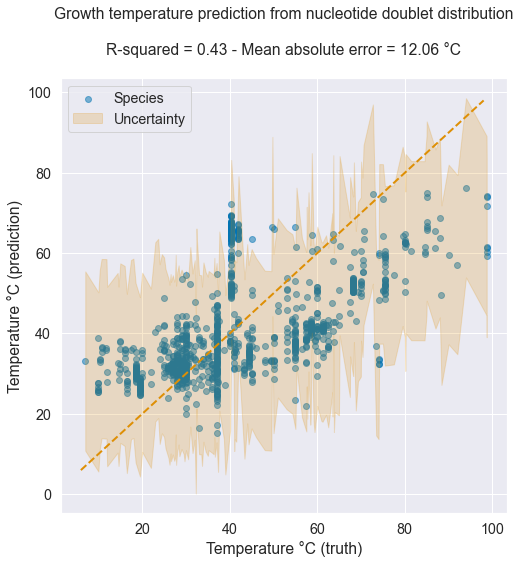

In [76]:
mae, r2, ax = fit_model_and_plot(doublet_bias)
ax.set_title((
    f'Growth temperature prediction from nucleotide doublet distribution\n\n'
    f'R-squared = {r2:.2f} - Mean absolute error = {mae:.2f} °C\n'
));

## Nucleotide bias

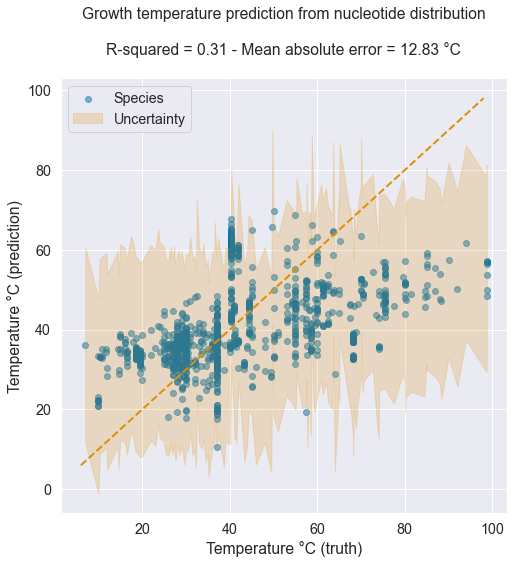

In [77]:
mae, r2, ax = fit_model_and_plot(nucleotide_bias)
ax.set_title((
    f'Growth temperature prediction from nucleotide distribution\n\n'
    f'R-squared = {r2:.2f} - Mean absolute error = {mae:.2f} °C\n'
));

## All together

In [78]:
possible_codons = sorted(CODON_REDUNDANCY.keys())
possible_doublets = [f'{a}{b}' for a, b in sorted(itertools.permutations(ALPHABET_DNA, 2))]

doublet_columns = [f'{c}_ratio' for c in possible_doublets]
triplet_columns = [f'{c}_ratio' for c in possible_codons]

combined_df = pd.concat(
    [
        nucleotide_bias.set_index('assembly_accession'),
        doublet_bias.set_index('assembly_accession')[doublet_columns],
        triplet_bias.set_index('assembly_accession')[triplet_columns],
    ],
    axis=1,
).reset_index()
combined_df.head()

,assembly_accession,species_taxid,in_test_set,A,C,G,T,A_ratio,C_ratio,G_ratio,...,TCG_ratio,TCT_ratio,TGA_ratio,TGC_ratio,TGG_ratio,TGT_ratio,TTA_ratio,TTC_ratio,TTG_ratio,TTT_ratio
0,GCA_000005825.2,79885,False,1589481,987485,1104093,1514536,0.305929,0.190062,0.212506,...,0.009728,0.016952,0.023118,0.015000,0.013974,0.015261,0.025424,0.019694,0.021254,0.031125
1,GCA_000005845.2,562,False,1341959,1374614,1459271,1338618,0.243353,0.249274,0.264626,...,0.015260,0.012318,0.019977,0.021149,0.022337,0.012565,0.014898,0.016006,0.016710,0.020713
2,GCA_000006175.2,2188,True,831476,306449,362019,730062,0.372858,0.137421,0.162340,...,0.006074,0.011747,0.018214,0.010268,0.012998,0.013879,0.040932,0.016391,0.020027,0.044815
3,GCA_000006605.1,38289,False,586107,929593,932665,561759,0.194712,0.308822,0.309843,...,0.021046,0.010342,0.013026,0.020352,0.023503,0.009397,0.004139,0.015074,0.010660,0.007282
4,GCA_000006685.1,83560,False,379185,255852,268679,390700,0.292939,0.197658,0.207568,...,0.010135,0.024899,0.015785,0.014669,0.014870,0.015866,0.022905,0.024235,0.021775,0.038979


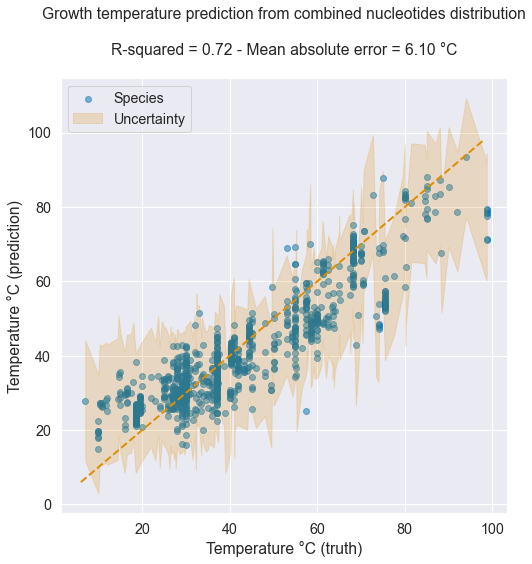

In [79]:
mae, r2, ax = fit_model_and_plot(combined_df)
ax.set_title((
    f'Growth temperature prediction from combined nucleotides distribution\n\n'
    f'R-squared = {r2:.2f} - Mean absolute error = {mae:.2f} °C\n'
));